In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, SplineTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, ElasticNetCV

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from joblib import dump

In [2]:
data = pd.read_csv("../data/wage_model.csv")
data = data.drop(columns = ['wage', 'region'])
y = data['logwage']

In [3]:
data

,year,age,maritl,race,education,jobclass,health,health_ins,logwage
0,2003,45,2. Married,1. White,3. Some College,1. Industrial,1. <=Good,1. Yes,4.875061
1,2006,50,2. Married,1. White,5. Advanced Degree,2. Information,2. >=Very Good,2. No,5.360552
2,2003,38,2. Married,3. Asian,4. College Grad,2. Information,2. >=Very Good,2. No,5.301030
3,2005,40,4. Divorced,1. White,2. HS Grad,2. Information,2. >=Very Good,2. No,3.920123
4,2007,40,2. Married,1. White,4. College Grad,2. Information,2. >=Very Good,2. No,5.079181
...,...,...,...,...,...,...,...,...,...
995,2005,40,2. Married,1. White,4. College Grad,1. Industrial,2. >=Very Good,1. Yes,4.875061
996,2008,32,1. Never Married,1. White,4. College Grad,2. Information,2. >=Very Good,1. Yes,5.000000
997,2009,50,2. Married,2. Black,2. HS Grad,1. Industrial,2. >=Very Good,2. No,4.886491
998,2007,35,2. Married,1. White,1. < HS Grad,1. Industrial,1. <=Good,2. No,4.698970


In [4]:
column_trans = ColumnTransformer(
    [('categorical', OneHotEncoder(dtype='int'), ['maritl', 'race', 'education', 'jobclass', 
                                                  'health', 'health_ins']),
     ('sp', Pipeline([('YJ', PowerTransformer()), ('spline', SplineTransformer())]), ['year', 'age'])]
)

column_trans.fit(data)
X = column_trans.transform(data)

In [5]:
column_trans.get_feature_names_out()

array(['categorical__maritl_1. Never Married',
       'categorical__maritl_2. Married', 'categorical__maritl_3. Widowed',
       'categorical__maritl_4. Divorced',
       'categorical__maritl_5. Separated', 'categorical__race_1. White',
       'categorical__race_2. Black', 'categorical__race_3. Asian',
       'categorical__race_4. Other',
       'categorical__education_1. < HS Grad',
       'categorical__education_2. HS Grad',
       'categorical__education_3. Some College',
       'categorical__education_4. College Grad',
       'categorical__education_5. Advanced Degree',
       'categorical__jobclass_1. Industrial',
       'categorical__jobclass_2. Information',
       'categorical__health_1. <=Good',
       'categorical__health_2. >=Very Good',
       'categorical__health_ins_1. Yes', 'categorical__health_ins_2. No',
       'sp__year_sp_0', 'sp__year_sp_1', 'sp__year_sp_2', 'sp__year_sp_3',
       'sp__year_sp_4', 'sp__year_sp_5', 'sp__year_sp_6', 'sp__age_sp_0',
       'sp__age_sp

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2022)

In [7]:
regr = ElasticNetCV(cv=5, random_state=2022)
regr.fit(X_train, y_train)

ElasticNetCV(cv=5, random_state=2022)

In [8]:
y_pred = regr.predict(X_test)

In [9]:
metrics_fun = [r2_score, mean_squared_error, mean_absolute_percentage_error]

metrics_res = [fun(y_test, y_pred) for fun in metrics_fun]

print (
    f'Metric | Value\n'
     '----------------\n'
    f'R2     | {metrics_res[0]:>.2%}\n'
    f'MSE    | {metrics_res[1]:>.4f}\n'
    f'RMSE   | {np.sqrt(metrics_res[1]):>.4f}\n'
    f'MAPE   | {metrics_res[2]:>.2%}\n'
)

Metric | Value
----------------
R2     | 37.53%
MSE    | 0.0793
RMSE   | 0.2816
MAPE   | 4.40%



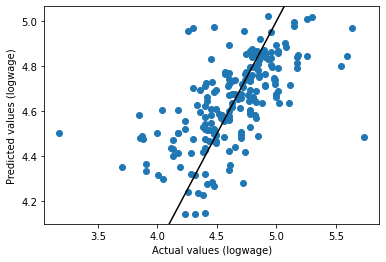

In [10]:
plt.scatter(y_test, y_pred)
plt.axline((np.mean(y_test), np.mean(y_test)), slope=1, color = 'black')
plt.xlabel("Actual values (logwage)")
plt.ylabel("Predicted values (logwage)")
plt.show()

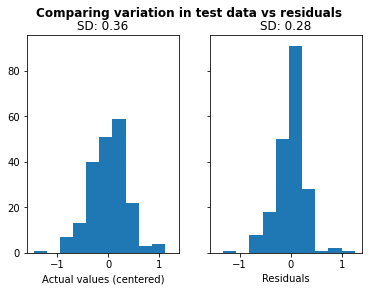

In [11]:
data = {'apple': 10, 'orange': 15, 'lemon': 5, 'lime': 20}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 2, sharex = True, sharey = True)
axs[0].hist(y_test - np.mean(y_test))
axs[0].set_xlabel('Actual values (centered)')
axs[0].set_title(f'SD: {np.std(y_test):.2f}')
axs[1].hist(y_test - y_pred)
axs[1].set_xlabel('Residuals')
axs[1].set_title(f'SD: {np.std(y_test - y_pred):.2f}')
fig.suptitle('Comparing variation in test data vs residuals',
             weight = 'bold')
plt.show()

In [12]:
final_regr = ElasticNet(alpha=regr.alpha_)
final_regr.fit(X, y)

ElasticNet(alpha=0.0043781170805865)

In [13]:
dump(column_trans, '../artifacts/column_trans.joblib')
dump(final_regr, '../artifacts/final_regr.joblib')

['../artifacts/final_regr.joblib']